In [210]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.optimize import minimize
import random

In [211]:
rdf = pd.read_csv('winequality-red.csv', sep=';')


Here we will do a 75%-15%-10% test split for train-validation-test respectively

In [212]:
rdf_train, rdf_val = train_test_split(rdf, test_size=0.25, random_state=50)
rdf_val, rdf_test = train_test_split(rdf_val, test_size=0.4, random_state=50)

In [213]:
X_train = rdf_train.drop('quality', axis=1)
y_train = rdf_train['quality']
X_test = rdf_test.drop('quality', axis=1)
y_test = rdf_test['quality']

Standardization:
$\mu_j$ is the mean and $\sigma_j$ is the standard deviation of feature $j$ across all data points. Each sample $x_n$ in each feature is replaced as follows:
$(x_n)_j \leftarrow \frac{(x_n)_j - \mu_j}{\sigma_j}$

Normalization:
$M_j$ and $m_j$ denote the maximum and minimum value of each feature $j$ respectively, across all data points. Then $(x_n)_j \leftarrow \frac{(x_n)_j - m_j}{M_j-m_j}$

In [214]:
#preprocessing

#standardization
X_train_values = X_train.values
X_test_values = X_test.values

X_train_mean = np.mean(X_train_values, axis=0)
X_train_std = np.std(X_train_values, axis=0, ddof=1)

def standardize(values, mean, std):
    return (values - mean) / std

X_train_standardized = standardize(X_train_values, X_train_mean, X_train_std)
X_test_standardized = standardize(X_test_values, X_train_mean, X_train_std)

#normalization
X_train_min = np.min(X_train_values, axis=0)
X_train_max = np.max(X_train_values, axis=0)

def normalize(values,mins,maxs):
    return (values - mins) / (maxs - mins)

X_train_normalized = normalize(X_train_values, X_train_min, X_train_max)
X_test_normalized = normalize(X_test_values, X_train_min, X_train_max)

Here, we define each regression function and its minimizers.

Ridge Regression: $E(w) = \frac{1}{2} \sum_{n=1}^{N} (t_n - w^T \phi (x_n))^2 + \frac{\lambda}{2} \sum_{j=1}^{M-1} w_j^2$

Lasso Regression: $E(w) = \frac{1}{2} \sum_{n=1}^{N} (t_n - w^T \phi (x_n))^2 + \lambda \sum_{j=1}^{M-1} |w_j|$

Sum of Squares: $E(w) = \frac{1}{2} \sum_{n=1}^{N} (t_n - w^T \phi (x_n))^2$


Minimizer of Ridge Regression: $w^* = (\lambda  I + \Phi^T \Phi)^{-1} \Phi^T t$

Minimizer of Lasso Regression: $w^* = \arg{\min{\{\frac{1}{2}||t-\Phi w||^2 + \lambda \sum_{j=1}^{M-1} |w_j|\}}}$

Minimizer of Sum of Squared: $w^* = (\Phi^T \Phi)^{-1} \Phi^T t$

In [215]:
#Ridge Regression

def m_ridge(X,t,lam=0.000000001):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    I = np.eye(X.shape[1])
    #I[0,0] = 0
    return np.linalg.inv((lam*I) + (X.T @ X)) @ (X.T @ t) #minimizer of the ridge regression

w_m_ridge_trs = m_ridge(X_train_standardized, y_train) #minimizer with standardized train set
w_m_ridge_trn = m_ridge(X_train_normalized, y_train) #minimizer with normalized train set
w_m_ridge_train = m_ridge(X_train, y_train) #minimizer with no featurization

def ridge_regr(w,t,X,lam=0.0000001):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return ((1/2)*np.sum((t-X@w)**2))+((lam/2)*(w.T@w)) #this is the ridge regression formula #try np.sum(w**2) 

'''Lasso Regression (needs to be fixed)

def lasso_regr(w,t,X,lam):
    #X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return ((1/2)*np.sum((t-X@w)**2))+(lam*np.sum(np.abs(w))) #this is the lasso regression formula

def m_lasso(X,t,lam):
    w_init = np.zeros(X.shape[1]+1)
    result = minimize(lasso_regr,w_init,args=(X,t,lam),method='SLSQP')
    return result.x #minimizer of the lasso regression using sequential least squares programming 

w_m_lasso_trs = m_lasso(X_train_standardized, y_train, 0.1)
w_m_lasso_trn = m_lasso(X_train_normalized, y_train, 0.1) 
w_m_lasso_tss = m_lasso(X_test_standardized, y_train, 0.1)
w_m_lasso_tsn = m_lasso(X_test_normalized, y_train, 0.1) '''

# Regular Linear Regression

def m_regression(X,t):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return np.linalg.pinv(X)@t #minimizer of the sum of squares error

w_m_regr_trs = m_regression(X_train_standardized, y_train) #standardized
w_m_regr_trn = m_regression(X_train_normalized, y_train) #normalized
w_m_regr_train = m_regression(X_train, y_train) #regular

def lin_regr(w,t,X): 
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return (1/2)*np.sum((t - X@w)**2) #sum of squares error for regression



To find the average error of each point we used the root mean square error: $\sqrt{\frac{2 E(w)}{N}}$

In [216]:
def rmse(regr,N): #Root mean square error
    return np.sqrt((2*regr)/N)

After tinkering with lambda:

In [217]:
ridge_test_norm = rmse(ridge_regr(w_m_ridge_trn, y_test, X_test_normalized),len(y_test)) #Ridge regression on normalized features
regr_test_norm = rmse(lin_regr(w_m_regr_trn,y_test,X_test_normalized),len(y_test)) #regular regression on normalized features
ridge_test = rmse(ridge_regr(w_m_ridge_train,y_test,X_test),len(y_test)) #Ridge regression on the un-featurized features
regr_test = rmse(lin_regr(w_m_regr_train,y_test,X_test),len(y_test)) #regular regression on the un-featurized features
ridge_test_std = rmse(ridge_regr(w_m_ridge_trs, y_test, X_test_standardized),len(y_test)) #Ridge regression on standardized features
regr_test_std = rmse(lin_regr(w_m_regr_trs, y_test, X_test_standardized),len(y_test)) #regular regression on standardized features

results = np.array([ridge_test_norm,regr_test_norm,ridge_test,regr_test,ridge_test_std,regr_test_std])
results = results.reshape(-1,1)
print(results)

metrics = {
    "ridge_test_norm": ridge_test_norm,
    "regr_test_norm": regr_test_norm,
    "ridge_test": ridge_test,
    "regr_test": regr_test,
    "ridge_test_std": ridge_test_std,
    "regr_test_std": regr_test_std
}

min_function = min(metrics, key=metrics.get)
min_value = metrics[min_function]
print(f"The function with the minimum value is '{min_function}' with a value of {min_value:}")



[[0.64309068]
 [0.64309066]
 [0.64309077]
 [0.64309066]
 [0.64309067]
 [0.64309066]]
The function with the minimum value is 'regr_test' with a value of 0.6430906550433568


We can conclude that the test with the least amount of average error is the Regular Regression on the Regular Train Set. All regressions have very similar results, however.

In [218]:
def pred(w,X):
    X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return X @ w

def alt_rmse(t,pred): #alternate version of the rmse
    return np.sqrt(np.mean((pred-t)**2))

regr_test_pred = pred(w_m_regr_train,X_test)
print(alt_rmse(regr_test_pred,y_test))

0.6430906550433568


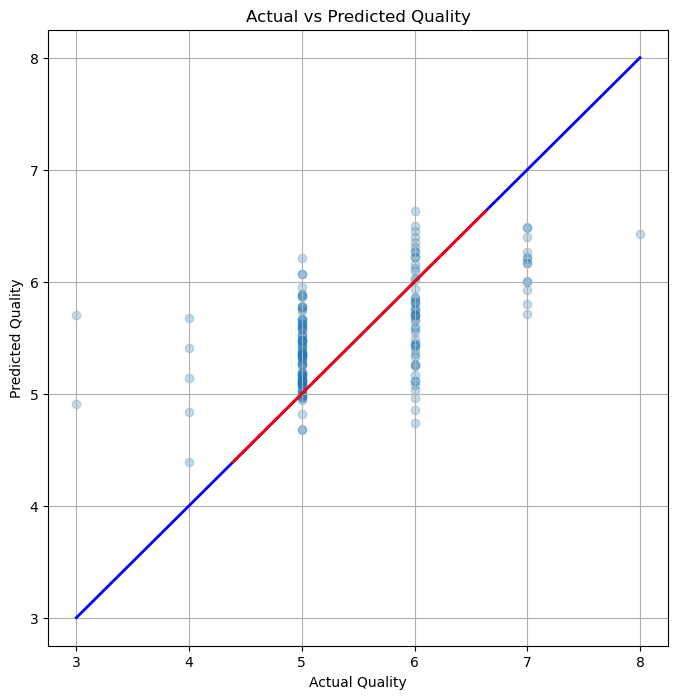

In [227]:
y = rdf['quality']

plt.figure(figsize=(8, 8))
plt.scatter(y_test, regr_test_pred, alpha=0.25)
#plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b', lw=2, linestyle=':')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'b', lw=2)
plt.plot([regr_test_pred.min(), regr_test_pred.max()], [regr_test_pred.min(), regr_test_pred.max()], 'r', lw=2,)
#plt.plot([regr_test_pred,regr_test_pred],'o',lw=2)
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.title('Actual vs Predicted Quality')
plt.grid(True)
plt.show()

We can see that the red line, which represents the slope of our predicted targets from the test set (red line), is extremely close to the actual targets of the entire dataset (blue line), which shows how low the error is of each model.